# Data Preprocessing

Il dataset, prima di tutto, va opportunamente elaborato per occuparsi di eventuali dati duplicati o mancanti. Inoltre dovremo separare i dati per ottenere un training e un test set.
Gli step che seguiremo saranno i seguenti:
1. Caricare i dati
2. Gestire i dati mancanti
3. Eliminare le features ridondanti
4. Dividere il dataset in training e test set
5. Normalizzare e standardizzare i dati

## Caricamento dei dati

Tramite `pandas` e il dataset fornito in .csv, carichiamo i dati all'interno di un dataset.

In [71]:
import pandas as pd
import numpy as np

weather_df = pd.read_csv('weather_dataset.csv', sep=',')  # Loading the dataset in a Pandas Dataframe
weather_df

,wind_speed,wind_direction,temperature,dew_point,air_pressure
0,60,260,35,32,10185
1,60,260,36,33,10183
2,60,260,37,34,10181
3,50,260,38,35,10174
4,50,260,39,36,10169
...,...,...,...,...,...
70123,60,250,86,63,10301
70124,50,250,82,65,10299
70125,60,240,82,63,10291
70126,60,250,81,61,10286


## Gestione dei dati mancanti

Con un `for-each` controlliamo, per ogni colonna, quanti sono i valori mancanti.

In [72]:
for column in weather_df.columns:
  number_of_nans_in_column = weather_df[column].isnull().sum()  # Per ogni colonna, somma il numero dei valori che sono null
  print(f"{column} -> {number_of_nans_in_column} missing values")

wind_speed -> 0 missing values
wind_direction -> 0 missing values
temperature -> 0 missing values
dew_point -> 0 missing values
air_pressure -> 0 missing values


Non essendoci valori nulli, procediamo direttamente con la prossima fase.

## Eliminazione di evenutali feature ridondanti

Si mettono in `correlazione` a due a due le feature, e in caso si eliminano feature ridondanti

<AxesSubplot:>

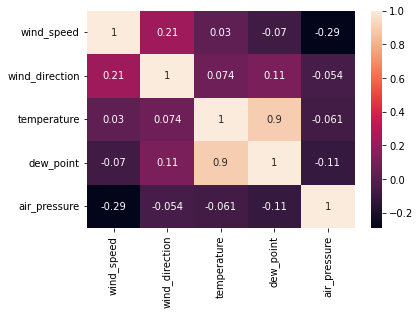

In [73]:
import seaborn as sns

correlations = weather_df.corr() # Calculating the correlations between the columns of the dataset 
sns.heatmap(correlations, annot = True)  # Displaying them in a heatmap

La temperatura e il punto di rugiada hanno una correlazione molto alta, pari a **0.9**.

Questa relazione è attribuibile alla relazione che le due feature hanno: il punto di rugiada è infatti calcolato sulla base della temperatura e dell'umidità relativa in un certo momento.
Visto che dobbiamo fare predizioni sulla temperatura, decidiamo di eliminare la feature "dew_points".

<img width="350" src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/2f/Dewpoint-RH.svg/800px-Dewpoint-RH.svg.png" 
    alt="grafico_temperatura_rugiada_wikipedia" />

In [74]:
print(list(weather_df.columns))
weather_df = weather_df.drop(columns=['dew_point'])
print(list(weather_df.columns))

['wind_speed', 'wind_direction', 'temperature', 'dew_point', 'air_pressure']
['wind_speed', 'wind_direction', 'temperature', 'air_pressure']


## Divisione del data set in training e test set

Si vuole dividere il data set in 3 parti:
1. Training set, comprendente tutte le righe tranne le ultime 168
2. Test set, comprendente solo le ultime 168 righe

In [75]:
training_set = weather_df[:-168]
test_set = weather_df[-168:]

### VALUTARE SE METTERE O NO PERCHÈ SPEZZA SERIE DI TEMPO -> SECONDO ME NO MA VEDIAMO COSA ESCE FUORI
Per evitare il problema dell'overfitting si vuole dividere il training set in 2 parti a sua volta:
1. Training set, contente l'80% dell'iniziale Training set
2. Validation set, contente il restante 20% dell'iniziale Training set

In [76]:
# from sklearn.model_selection import train_test_split

# training_set, validation_set = train_test_split(training_set, test_size=0.2)

# print(f"The training set is:\n{training_set}\n")
# print(f"The testing set is:\n{validation_set}\n")

## Standardizzazione e normalizzazione dei dati

Per `facilitare la fase di apprendimento` si scalano i dati del dataset.

In [77]:
from sklearn.preprocessing import StandardScaler
standard_scaler = StandardScaler()

training_set_scaled = standard_scaler.fit_transform(training_set)
test_set_scaled = standard_scaler.transform(test_set)

print(f"First 10 values in training set before are:\n{training_set.head(10)}\nafter they are:\n{training_set_scaled[:10]}")
print(f"First 10 values in testing set before are:\n{test_set.head(10)}\nafter they are:\n{test_set_scaled[:10]}")

First 10 values in training set before are:
   wind_speed  wind_direction  temperature  air_pressure
0          60             260           35         10185
1          60             260           36         10183
2          60             260           37         10181
3          50             260           38         10174
4          50             260           39         10169
5          60             260           43         10165
6          60             300           44         10171
7          40             290           40         10174
8          40             300           37         10179
9          30             290           40         10181
after they are:
[[ 0.8001791   0.80484909 -0.97017729  0.34613392]
 [ 0.8001791   0.80484909 -0.95547013  0.32548664]
 [ 0.8001791   0.80484909 -0.94076297  0.30483935]
 [ 0.37388489  0.80484909 -0.92605581  0.23257385]
 [ 0.37388489  0.80484909 -0.91134865  0.18095564]
 [ 0.8001791   0.80484909 -0.85252001  0.13966106]
 [ 0.80

**Questa roba qua sotto non so bene come spiegarla ma praticamente divido i due set in "roba che per fittare" e "soluzione di quello che deve predire"**

Quindi ogni 3 righe in train_x ne salvo 1 in train_y, che ipotizzo sia quella da predire
Passo successivo ripeto il procedimento traslando di 1 posizione verso l'ultima posizione l'iteratore.

In [85]:
def split_sequence(sequence, n_steps):
    x, y = list(), list()

    for i in range(len(sequence)):
        end_ix = i + n_steps
        
        if end_ix > len(sequence)-1:
            break

        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]  # Ogni n_step volte, salva la riga dopo come l'informazione che il modello dovrà predire
        x.append(seq_x)
        y.append(seq_y)

    return x,y

n_steps = 3
train_x, train_y = split_sequence(training_set_scaled, n_steps)
test_x, test_y = split_sequence(test_set_scaled, n_steps)

print(train_y[:10])
# print(f"First 10 values in training set before are:\n{train_x[:10]}\nafter they are:\n{train_y[:10]}")
# print(f"First 10 values in testing set before are:\n{test_x[:10]}\nafter they are:\n{test_y[:10]}")

[array([ 0.37388489,  0.80484909, -0.92605581,  0.23257385]), array([ 0.37388489,  0.80484909, -0.91134865,  0.18095564]), array([ 0.8001791 ,  0.80484909, -0.85252001,  0.13966106]), array([ 0.8001791 ,  1.24247071, -0.83781285,  0.20160292]), array([-0.05240933,  1.1330653 , -0.89664149,  0.23257385]), array([-0.05240933,  1.24247071, -0.94076297,  0.28419207]), array([-0.47870354,  1.1330653 , -0.89664149,  0.30483935]), array([-0.05240933,  1.24247071, -0.82310569,  0.30483935]), array([ 0.8001791 ,  1.24247071, -0.82310569,  0.315163  ]), array([ 0.37388489,  1.24247071, -0.85252001,  0.315163  ])]


Definiamo il modello di CNN che andremo ad utilizzare.

# **DA QUI IN POI NON HO TESTATO**, GUARDA IN FONDO PER I LINK CHE HO USATO

In [79]:
import torch

batch_size = 3
input_size = 3
hidden_dim = 16
output_size = 4


class WeatherCNN(torch.nn.Module):
    def __init__(self):
        super(WeatherCNN, self).__init__()
        self.conv1d = torch.nn.Conv1d(input_size, hidden_dim, kernel_size=2)
        self.relu = torch.nn.ReLU()
        self.fc1 = torch.nn.Linear(144, 10)
        self.fc2 = torch.nn.Linear(10, output_size)
        
        # ALTRA POSSIBILE CNN (DA CONVERIRE PERCHÈ QUESTA È IN KERAS)
        #model = Sequential()
        #model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps_in, n_features)))
        #model.add(MaxPooling1D(pool_size=2))
        #model.add(Flatten())
        #model.add(Dense(50, activation='relu'))
        #model.add(Dense(n_output))
        
    def forward(self,x):
        x = self.conv1d(x)
        x = self.relu(x)
        x = x.view(-1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        
        return x

Impostiamo la GPU, se possibile

In [80]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = WeatherCNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
criterion = torch.nn.MSELoss()
device

device(type='cuda')

Inseriamo i dati nei tensori e successivamente dei DataLoader

In [81]:
import torch
from torch.utils.data import TensorDataset

tensor_ids_train = torch.FloatTensor(train_x)
labels_train = torch.FloatTensor(train_y)
train_dataset = TensorDataset(tensor_ids_train, labels_train)

tensor_ids_test = torch.FloatTensor(test_x)
labels_test = torch.FloatTensor(test_y)
test_dataset = TensorDataset(tensor_ids_test, labels_test)

Impostiamo i tensori nei dataloader (che servono per impostare i batch)

In [82]:
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=3,shuffle=False)
valid_loader = torch.utils.data.DataLoader(test_dataset,batch_size=3,shuffle=False)

Funzioni di training e di test:

In [83]:
train_losses = []
valid_losses = []
def Train():
    
    running_loss = .0
    
    model.train()
    
    for idx, (inputs,labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        preds = model(inputs.float())
        print(preds, labels)
        loss = criterion(preds,labels)
        loss.backward()
        optimizer.step()
        running_loss += loss
        
    train_loss = running_loss/len(train_loader)
    train_losses.append(train_loss.detach().cpu().data.numpy())
    
    print(f'train_loss {train_loss}')
    
def Valid():
    running_loss = .0
    
    model.eval()
    
    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(valid_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            print(labels)
            optimizer.zero_grad()
            preds = model(inputs.float())
            loss = criterion(preds,labels)
            running_loss += loss
            
        valid_loss = running_loss/len(valid_loader)
        valid_losses.append(valid_loss.detach().cpu().data.numpy())
        print(f'valid_loss {valid_loss}')

Codice di training e testing per le epoche

In [84]:
epochs = 10

for epoch in range(epochs):
    print('epochs {}/{}'.format(epoch+1,epochs))
    Train()
    Valid()

epochs 1/10
tensor([ 0.2922,  0.2157, -0.3799, -0.2037], device='cuda:0',
       grad_fn=<AddBackward0>) tensor([[ 0.3739,  0.8048, -0.9261,  0.2326],
        [ 0.3739,  0.8048, -0.9113,  0.1810],
        [ 0.8002,  0.8048, -0.8525,  0.1397]], device='cuda:0')
tensor([ 0.3026,  0.2001, -0.3381, -0.2185], device='cuda:0',
       grad_fn=<AddBackward0>) tensor([[ 0.8002,  1.2425, -0.8378,  0.2016],
        [-0.0524,  1.1331, -0.8966,  0.2326],
        [-0.0524,  1.2425, -0.9408,  0.2842]], device='cuda:0')
tensor([ 0.2644,  0.1485, -0.3893, -0.1371], device='cuda:0',
       grad_fn=<AddBackward0>) tensor([[-0.4787,  1.1331, -0.8966,  0.3048],
        [-0.0524,  1.2425, -0.8231,  0.3048],
        [ 0.8002,  1.2425, -0.8231,  0.3152]], device='cuda:0')
tensor([ 0.2938,  0.1904, -0.3694, -0.1820], device='cuda:0',
       grad_fn=<AddBackward0>) tensor([[ 0.3739,  1.2425, -0.8525,  0.3152],
        [ 0.3739,  1.3519, -0.9261,  0.3358],
        [ 0.3739,  1.2425, -1.0437,  0.3771]], device='c

C:\Users\rikyn\miniconda3\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([3, 4])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



tensor([ 0.2903,  0.2175, -0.4140, -0.1770], device='cuda:0',
       grad_fn=<AddBackward0>) tensor([[-0.0524,  1.1331, -0.9996,  0.6455],
        [ 0.3739,  1.2425, -1.0143,  0.6558],
        [ 0.3739,  1.5707, -1.1761,  0.6868]], device='cuda:0')
tensor([ 0.2930,  0.1725, -0.4155, -0.1547], device='cuda:0',
       grad_fn=<AddBackward0>) tensor([[-0.0524,  1.3519, -1.2643,  0.6765],
        [-0.9050,  0.9143, -1.3379,  0.7075],
        [-0.4787,  0.9143, -1.4408,  0.7075]], device='cuda:0')
tensor([ 0.2770,  0.1764, -0.4171, -0.1675], device='cuda:0',
       grad_fn=<AddBackward0>) tensor([[-0.4787,  1.0237, -1.3673,  0.7281],
        [-0.4787,  0.8048, -1.4996,  0.7384],
        [-0.4787,  1.0237, -1.4849,  0.7384]], device='cuda:0')
tensor([ 0.2737,  0.2028, -0.4314, -0.1618], device='cuda:0',
       grad_fn=<AddBackward0>) tensor([[-0.4787,  0.9143, -1.4702,  0.7488],
        [-0.9050,  0.8048, -1.6467,  0.7591],
        [-0.4787,  0.8048, -1.7349,  0.7694]], device='cuda:0')
ten

KeyboardInterrupt: 

Il resto continua qua: [cnn-time-series-forecasting-with-pytorch ](https://www.kaggle.com/hanjoonchoe/cnn-time-series-forecasting-with-pytorch/notebook)

Qui spiega anche la roba ricorsiva che dice: [Walk Forward Validation](https://machinelearningmastery.com/how-to-develop-lstm-models-for-multi-step-time-series-forecasting-of-household-power-consumption/#:~:text=2083.4539999999984%202197.006000000004-,Walk%2DForward%20Validation,-Models%20will%20be), però non l'ho ancora provata.

In [ ]:
import torch

rnn = torch.nn.RNN(10, 20, 2)
input = torch.randn(5, 3, 10)
h0 = torch.randn(2, 3, 20)
output, hn = rnn(input, h0)

print('input', input)
print('output',output)

tensor([[[-3.0699, -0.9394,  1.0814, -0.3805, -0.7711,  1.6172, -0.9587,
          -0.3224,  1.3918,  0.5806],
         [-0.6569,  0.5398,  0.5302, -0.1326, -0.0631,  1.5699,  1.6834,
           0.7542,  0.5336,  1.3452],
         [-0.5040, -0.2619, -0.6158, -0.7944,  0.2041,  0.1418,  1.4594,
          -1.3172, -0.4028,  0.7433]],

        [[ 0.8458, -0.7810,  0.4293,  0.9747, -0.1321, -0.0632, -1.7557,
           0.4034, -0.8568,  0.4505],
         [ 1.2986, -0.4778, -0.7958,  2.3916,  0.5818,  0.5523,  0.1864,
          -0.1734, -0.8546, -0.6350],
         [ 0.1382, -1.5042, -0.1440, -0.1450, -0.8777,  0.3077, -2.3067,
          -1.8442, -1.0325,  0.0290]],

        [[ 0.3428,  0.5908, -0.5529,  1.1918, -0.4990,  1.4645,  0.4755,
           0.2378,  0.8142, -0.1088],
         [-0.0258,  2.2126, -0.4163,  0.5760, -1.6196,  0.1369,  0.2212,
          -1.0659, -0.5246,  0.7668],
         [-1.3122,  0.3727, -2.0804, -0.2390,  0.2847,  0.3357, -0.9592,
           1.4768, -0.1173,  1.7587

# [Link che potrebbe essere utile ](https://www.tensorflow.org/tutorials/structured_data/time_series)